# Prophet predictor
This notebook contains a timeseries predictor model built with the fbprophet library. 

## Training

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

### Copy the data locally

In [2]:
# Main source for the training data
DATA_URL = 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv'
# Local file
DATA_FILE = 'data/OxCGRT_latest.csv'

In [3]:
import os
import urllib.request
if not os.path.exists('data'):
    os.mkdir('data')
urllib.request.urlretrieve(DATA_URL, DATA_FILE)

('data/OxCGRT_latest.csv', <http.client.HTTPMessage at 0x7f43fe0dce10>)

In [4]:
# Load historical data from local file
df = pd.read_csv(DATA_FILE, 
                 parse_dates=['Date'],
                 encoding="ISO-8859-1",
                 dtype={"RegionName": str,
                        "RegionCode": str},
                 error_bad_lines=False)

In [5]:
df.columns

Index(['CountryName', 'CountryCode', 'RegionName', 'RegionCode',
       'Jurisdiction', 'Date', 'C1_School closing', 'C1_Flag',
       'C2_Workplace closing', 'C2_Flag', 'C3_Cancel public events', 'C3_Flag',
       'C4_Restrictions on gatherings', 'C4_Flag', 'C5_Close public transport',
       'C5_Flag', 'C6_Stay at home requirements', 'C6_Flag',
       'C7_Restrictions on internal movement', 'C7_Flag',
       'C8_International travel controls', 'E1_Income support', 'E1_Flag',
       'E2_Debt/contract relief', 'E3_Fiscal measures',
       'E4_International support', 'H1_Public information campaigns',
       'H1_Flag', 'H2_Testing policy', 'H3_Contact tracing',
       'H4_Emergency investment in healthcare', 'H5_Investment in vaccines',
       'H6_Facial Coverings', 'H6_Flag', 'H7_Vaccination policy', 'H7_Flag',
       'M1_Wildcard', 'ConfirmedCases', 'ConfirmedDeaths', 'StringencyIndex',
       'StringencyIndexForDisplay', 'StringencyLegacyIndex',
       'StringencyLegacyIndexForDispla

In [6]:
# Add RegionID column that combines CountryName and RegionName for easier manipulation of data
df['GeoID'] = df['CountryName'] + '__' + df['RegionName'].astype(str)

In [7]:
# Add new cases column
df['NewCases'] = df.groupby('GeoID').ConfirmedCases.diff().fillna(0)

In [8]:
# Keep only columns of interest
id_cols = ['CountryName',
           'RegionName',
           'GeoID',
           'Date']
cases_col = ['NewCases']
npi_cols = ['C1_School closing',
            'C2_Workplace closing',
            'C3_Cancel public events',
            'C4_Restrictions on gatherings',
            'C5_Close public transport',
            'C6_Stay at home requirements',
            'C7_Restrictions on internal movement',
            'C8_International travel controls',
            'H1_Public information campaigns',
            'H2_Testing policy',
            'H3_Contact tracing',
            'H6_Facial Coverings']

df = df[id_cols + cases_col + npi_cols]

In [9]:
# Fill any missing case values by interpolation and setting NaNs to 0
df.update(df.groupby('GeoID').NewCases.apply(
    lambda group: group.interpolate()).fillna(0))

In [10]:
# Fill any missing NPIs by assuming they are the same as previous day
for npi_col in npi_cols:
    df.update(df.groupby('GeoID')[npi_col].ffill().fillna(0))

In [11]:
from pandas import read_csv
from pandas import to_datetime
from pandas import DataFrame
from fbprophet import Prophet
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot

# Setup utils functions
HYPOTHETICAL_SUBMISSION_DATE = np.datetime64("2020-11-15")


def get_reduced_country_df(df: pd.DataFrame, countries: list)-> pd.DataFrame:
    """
    Given a input dataset, returns a dataframe of the country specified
    example get_reduced_country_df(df=df, countries=['Canada__nan'])
    """
    return df[df['GeoID'].isin(countries)]

def augment_prophet_cols(df: pd.DataFrame)-> pd.DataFrame:
    """Adds prophet specific ds & y cols to a df and sets index
    to datetime
    """
    df['ds'] = to_datetime(df['Date'])
    df['y'] = df['NewCases']
#     df.index = df['ds']
    
    return df
    
    
def get_modeling_sets(countries:list):
    """Returns a tain/test dataset of countries specified"""
    reduced_df = get_reduced_country_df(df=df, countries=countries)
    
    train = reduced_df[reduced_df.Date <= HYPOTHETICAL_SUBMISSION_DATE]
    augmented_train = augment_prophet_cols(train)
    
    test = reduced_df[reduced_df.Date > HYPOTHETICAL_SUBMISSION_DATE]
    augmented_test = augment_prophet_cols(test) 
    
    return  augmented_train, augmented_test

In [12]:
# install prophet & sktime
#!pip install fbprophet
#!pip install sktime[all_extras]

# check prophet version
import fbprophet
# print version number
print('Prophet %s' % fbprophet.__version__)

Prophet 0.7.1


In [25]:
# modeling utils
def fit_multi_reg_model(features:list, train: list) :
    """Util function to define a multi regressor model"""
    multi_reg_model = Prophet(interval_width=0.95, seasonality_mode='multiplicative')

    for feature in features:
        multi_reg_model.add_regressor(feature, standardize=False,)

    multi_reg_model.fit(train)
    
    return multi_reg_model

def get_predictions(model, test, country):
    """Forecast predictions from 16/11/2020 to 06-12-2020"""
    future = test[
        (np.datetime64("2020-12-06") >= test.Date) &
        (test.CountryName == country)
    ]
    future['ds'] = future['Date']
    forecast = model.predict(future)
    y_pred = forecast['yhat'].values
    
    return y_pred

## Region Canada

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Canada MAE: 629.624


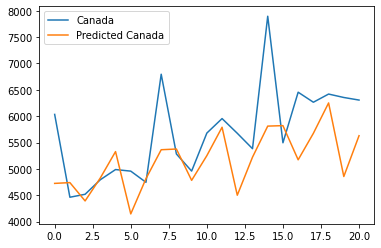

In [26]:
# calculate MAE between expected and predicted values
train, test = get_modeling_sets(['Canada__nan'])

model =  fit_multi_reg_model(features=npi_cols, train=train)

for country in ['Canada']:
    y_multi_reg_pred = get_predictions(model, test, country)
    y_true_df = test[(np.datetime64("2020-12-06") >= test.Date)]
    y_true= y_true_df[y_true_df['CountryName'] == 'Canada']['NewCases'].values
    mae = mean_absolute_error(y_true, y_multi_reg_pred)
    print(f'{country} MAE: %.3f' % mae)
    # plot expected vs actual
    pyplot.plot(y_true, label=country)
    pyplot.plot(y_multi_reg_pred, label=f'Predicted {country}')

pyplot.legend()
pyplot.show()

## Region US

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Aruba MAE: 21.747


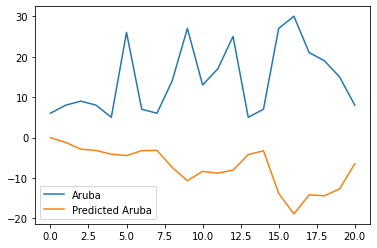

In [29]:
# calculate MAE between expected and predicted values
train, test = get_modeling_sets(['Aruba__nan'])

model =  fit_multi_reg_model(features=npi_cols, train=train)

for country in ['Aruba']:
    y_multi_reg_pred = get_predictions(model, test, country)
    y_true_df = test[(np.datetime64("2020-12-06") >= test.Date)]
    y_true= y_true_df[y_true_df['CountryName'] == country]['NewCases'].values
    mae = mean_absolute_error(y_true, y_multi_reg_pred)
    print(f'{country} MAE: %.3f' % mae)
    # plot expected vs actual
    pyplot.plot(y_true, label=country)
    pyplot.plot(y_multi_reg_pred, label=f'Predicted {country}')

pyplot.legend()
pyplot.show()